---  
title: "状態遷移行列に関するノートブック"  
author: "Naoya Ozaki"  
date: "25 November 2025"  
output: "state_transition_matrix"  

---  

# 状態遷移行列に関するノートブック

## 1. 二体問題の場合の状態遷移行列
二体問題の運動方程式である
$$
\frac{d^2\boldsymbol{r}}{dt^2} = -\frac{GM}{r^3}\boldsymbol{r}
$$
および
$$
\frac{d}{dt}\Phi(t,t_0) = \begin{bmatrix} O & I\\
\frac{\partial \boldsymbol{a}}{\partial \boldsymbol{r}} & O
\end{bmatrix}\Phi(t,t_0)
$$
を`scipy.integrate`を用いて伝播する．但し，$\boldsymbol{r}=[x,y,z]$は中心天体に対する宇宙機の3次元位置ベクトルである．$r$は$\boldsymbol{r}$の大きさ（ノルム）を表す．$GM$は中心天体の重力定数である．また，
$$
\frac{\partial \boldsymbol{a}}{\partial \boldsymbol{r}} = -\frac{GM}{r^3}\left(I-\frac{3\boldsymbol{r}\boldsymbol{r}^T}{r^2}\right)
$$
である．

In [35]:
# Pythonのモジュールをインポート
import numpy as np # 数値計算ライブラリ
from scipy.integrate import odeint # 常微分方程式を解くライブラリ

# 二体問題の運動方程式
def func(x, t):
    """二体問題の運動方程式

    Args:
        x (np.ndarray): 状態量 (位置＋速度) + STM
        t (float): 時刻

    Returns:
        np.ndarray: 状態量の時間微分
    """
    GM = 398600.4354360959 # 地球の重力定数, km3/s2
    r = np.linalg.norm(x[0:3])
    stm = x[6:42].reshape((6,6))
    dadr = -GM/(r**3)*(np.identity(3) - 3.0*np.outer(x[0:3],x[0:3])/(r**2))
    dstmdt = np.dot(np.block([[np.zeros((3,3)),np.identity(3)],[dadr, np.zeros((3,3))]]), stm)
    dxdt = np.block([x[3:6], 
                     -GM/(r**3)*x[0:3],
                     dstmdt.flatten()])
    return dxdt 

# 微分方程式の初期条件
GM = 398600.4354360959 # 地球の重力定数, km3/s2
r0 = 42164 # km
x0 = np.array([r0, 0, 0, 0, np.sqrt(GM/r0), 0])
stm0 = np.identity(6)
t  = np.linspace(0, 0.5*86400, 1000) # 半日分 軌道伝播

# 微分方程式の数値計算
sol = odeint(func, np.block([x0, stm0.flatten()]), t)
stm = [ sol_[6:42].reshape((6,6)) for sol_ in sol ]


In [36]:
def inverse_or_nan(matrix_A):
    """
    正則行列であれば逆行列を計算し、
    非正則行列であれば NaN を返します。
    """
    # 行列式を計算
    det_A = np.linalg.det(matrix_A)

    # 浮動小数点数の比較は誤差があるため、特定のしきい値（例: 1e-9）と比較することが一般的です
    if np.isclose(det_A, 0):
        # 行列と同じ形状のNaN配列を作成して返す
        # np.full() や np.empty() などで作成可能
        rows, cols = matrix_A.shape
        return np.full((rows, cols), np.nan)
    else:
        # 逆行列を計算して返す
        return np.linalg.inv(matrix_A)

stm_rv = [stm_[0:3,3:6] for stm_ in stm]
drT = [-1.0, 0.0, 0.0]
dv_sensitivity = [np.linalg.norm(np.dot(inverse_or_nan(stm_rv_),drT)) for stm_rv_ in stm_rv ]

dv_sensitivity

[nan,
 0.023124923352499823,
 0.011562346705592367,
 0.007708103399103558,
 0.005780943435456723,
 0.004624616817677463,
 0.003853706882203791,
 0.0033030350607252826,
 0.002890012070644346,
 0.002568754978612036,
 0.002311734025786226,
 0.00210143027591772,
 0.0019261644391839771,
 0.0017778508543629483,
 0.001650714050059322,
 0.001540518681414758,
 0.00144408824053956,
 0.0013589936339399868,
 0.001283345567281159,
 0.0012156524931009628,
 0.0011547211741087574,
 0.0010995856568749363,
 0.0010494556163795025,
 0.001003678176001279,
 0.0009617092723986035,
 0.0009230918928608039,
 0.0008874393347998181,
 0.0008544221853566445,
 0.0008237580910919992,
 0.0007952036442926583,
 0.000768547892016893,
 0.0007436071014530626,
 0.0007202205067740736,
 0.0006982468292905484,
 0.000677561411694954,
 0.0006580538435778004,
 0.0006396259826914532,
 0.0006221902970898051,
 0.0006056684690355541,
 0.0005899902136908245,
 0.0005750922750042553,
 0.0005609175685414363,
 0.0005474144467680268,
 0.00

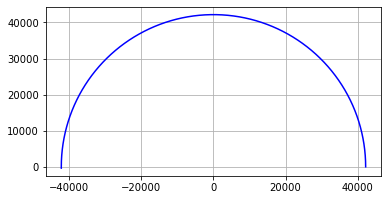

In [37]:
# 結果の描画
import matplotlib.pyplot as plt # 描画ライブラリ

# 描画
plt.plot(sol[:, 0],sol[:, 1], 'b')
plt.grid() # 格子をつける
plt.gca().set_aspect('equal') # グラフのアスペクト比を揃える
plt.show()

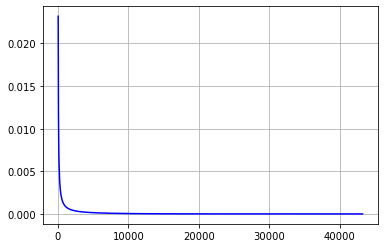

In [38]:
# 結果の描画
import matplotlib.pyplot as plt # 描画ライブラリ

# 描画
plt.plot(t,dv_sensitivity, 'b')
plt.grid() # 格子をつける
plt.show()